### 0. Initial Configuration

Necesssary libraries are imported. The MLPs will be implemented via keras. Additionally, reproducibility is established.

In [1]:
!pip install -q imblearn xgboost pydot graphviz

In [2]:
# 0.1 - General Purpose Libraries/Modules

# for linear algebra
import numpy as np
# for data processing and file I/O
import pandas as pd
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# measuring latency
import time

# Encode categorical target variable into numerical labels
from sklearn.preprocessing import LabelEncoder
# for data preparation
from sklearn.model_selection import train_test_split
# for feature engineering and data scaling
from sklearn.preprocessing import Normalizer, QuantileTransformer
# for feature engineering
from sklearn.feature_selection import mutual_info_classif
# for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# for SMOTE
from imblearn.over_sampling import SMOTE
# for confusion matrix
from sklearn.metrics import confusion_matrix

# for I/O & automatic EDA
import os
# for suppressing warnings
import warnings
# for reating the report
from IPython.display import display, HTML
# Attention: Importing this module on GPU creates bugs
#from ydata_profiling import ProfileReport

In [3]:
# 0.2 - The MLPs are implemented via keras

# for feature selection
from xgboost import XGBClassifier

# basic configuration
import tensorflow as tf
from tensorflow import keras

# for the implemantation of the models
from keras import layers, Sequential
# for readability purposes
from keras.layers import Input, Dense
# for weights initialization
from keras.initializers import GlorotUniform, HeUniform
# for loadig (after saving) the models
from keras.models import load_model

# for the customization of the model and the training process
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# for model visualization
from keras.utils import plot_model

2024-12-31 14:51:52.803226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# 0.3 - Reproducibility Establishment

# Set seed
seed_pi = 314159

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

# 1. Dataset Preperation

In this segment, we proceed with dataset loading and preprocessing.

# 1.1 Importing the CIC-IDS-2017 Dataset

The dataset will be loaded from an [Apache Parquet file](https://parquet.apache.org/) into a Pandas DataFrame. It has been properly cleaned and preprocessed by Kaggle user [StrGenIx | Laurens D'hooge](https://www.kaggle.com/datasets/dhoogla/cicids2017).

In [5]:
# 1.1.1 - Directory Inspection

# Running this will list all files under the input directory

for dirname, _, filenames in os.walk('/home/jovyan/.cache/kagglehub/datasets/dhoogla'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/3.complete
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Botnet-Friday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Portscan-Friday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/DoS-Wednesday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/DDoS-Friday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/WebAttacks-Thursday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Benign-Monday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Infiltration-Thursday-no-metadata.parquet
/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Bruteforce-Tuesday-no-metadata.parquet


In [6]:
# 1.1.2 - Loading the datasets into dataframes

df_data_1 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Botnet-Friday-no-metadata.parquet')
df_data_3 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Bruteforce-Tuesday-no-metadata.parquet')
df_data_4 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/DDoS-Friday-no-metadata.parquet')
df_data_5 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Infiltration-Thursday-no-metadata.parquet')
df_data_7 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/Portscan-Friday-no-metadata.parquet')
df_data_8 = pd.read_parquet('/home/jovyan/.cache/kagglehub/datasets/dhoogla/cicids2017/versions/3/WebAttacks-Thursday-no-metadata.parquet')

In [7]:
# 1.1.3 - Concatenating the dataframes to single dataframe

df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4, 
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

# 1.2 Data Preproccesing

The data preprocessing phase involves the removal of all anomalous samples. In this initial approach, a binary configuration is adopted. During this stage, the features and the target variable are established.

In [8]:
# 1.2.1 - Data preprocessing

# Find and handle null values
null_counts = df_data.isnull().sum()
# Print the number of null values
print(f"{null_counts.sum()} null entries have been found in the dataset\n")
# Drop null values
df_data.dropna(inplace=True)          # or df_data = df_data.dropna()

# Find and handle duplicates
duplicate_count = df_data.duplicated().sum()
# Print the numer of duplicate entries
print(f"{duplicate_count} duplicate entries have been found in the dataset\n")
# Remove duplicates
df_data.drop_duplicates(inplace=True)  # or df_data = df_data.drop_duplicates()
# Display relative message
print(f"All duplicates have been removed\n")

# Reset the indexes
df_data.reset_index(drop=True, inplace=True)

# Inspect the dataset for categorical columns
print("Categorical column:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

# Print the first 5 lines
df_data.head()

0 null entries have been found in the dataset

82004 duplicate entries have been found in the dataset

All duplicates have been removed

Categorical column: ['Label'] 



Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6              4                  2                       0   
1         6              1                  2                       0   
2         6              3                  2                       0   
3         6              1                  2                       0   
4         6            609                  7                       4   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                        12                         0                      6   
1                        12                         0                      6   
2                        12                         0                      6   
3                        12                         0                      6   
4                       484                       414                    233   

   Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  ...  \
0                      6                 6.00000               0.000000  ...   
1                      6                 6.00000               0.000000  ...   
2                      6                 6.00000               0.000000  ...   
3                      6                 6.00000               0.000000  ...   
4                      0                69.14286             111.967896  ...   

   Fwd Seg Size Min  Active Mean  Active Std  Active Max  Active Min  \
0                20          0.0         0.0           0           0   
1                20          0.0         0.0           0           0   
2                20          0.0         0.0           0           0   
3                20          0.0         0.0           0           0   
4                20          0.0         0.0           0           0   

   Idle Mean  Idle Std  Idle Max  Idle Min   Label  
0        0.0       0.0         0         0  Benign  
1        0.0       0.0         0         0  Benign  
2        0.0       0.0         0         0  Benign  
3        0.0       0.0         0         0  Benign  
4        0.0       0.0         0         0  Benign  

[5 rows x 78 columns]

In [9]:
# # 1.2.2 - Inspection of Target Feature

print('Shape of Dataframe: ',df_data.shape,'\n')
print('Inspection of Target Feature - y:\n')
# Target feature counts
print(df_data['Label'].value_counts())
# Alternatively:
# df_data.Label.value_counts()

Shape of Dataframe:  (2231806, 78) 

Inspection of Target Feature - y:

Label
Benign                        1895314
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [10]:
# 1.2.3 - Set up binary & multi-class configurations

# Extract features as X
X = df_data.copy()
X = X.drop('Label', axis=1)

# Extract binary target as y
y = df_data['Label'].copy()

" Binary Configuration"

# Binarize labels
y_b = y.map({'Benign': 0}).fillna(1)

""" Multi-class Configuration """

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Extract multi-class configuration as y_m
y_m = pd.Series(y_encoded)

# Inspect encoding
print('Inspection of Target Feature - y under Multiclass Configuration:\n')
y_m.value_counts()

Inspection of Target Feature - y under Multiclass Configuration:



0     1895314
4      172846
2      128014
3       10286
7        5931
6        5385
5        5228
11       3219
10       1956
12       1470
1        1437
14        652
9          36
13         21
8          11
Name: count, dtype: int64

*As evident from the output of cell 1.2.2 & 1.2.3, the dataset exhibits a significant class imbalance in both configurations:*

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

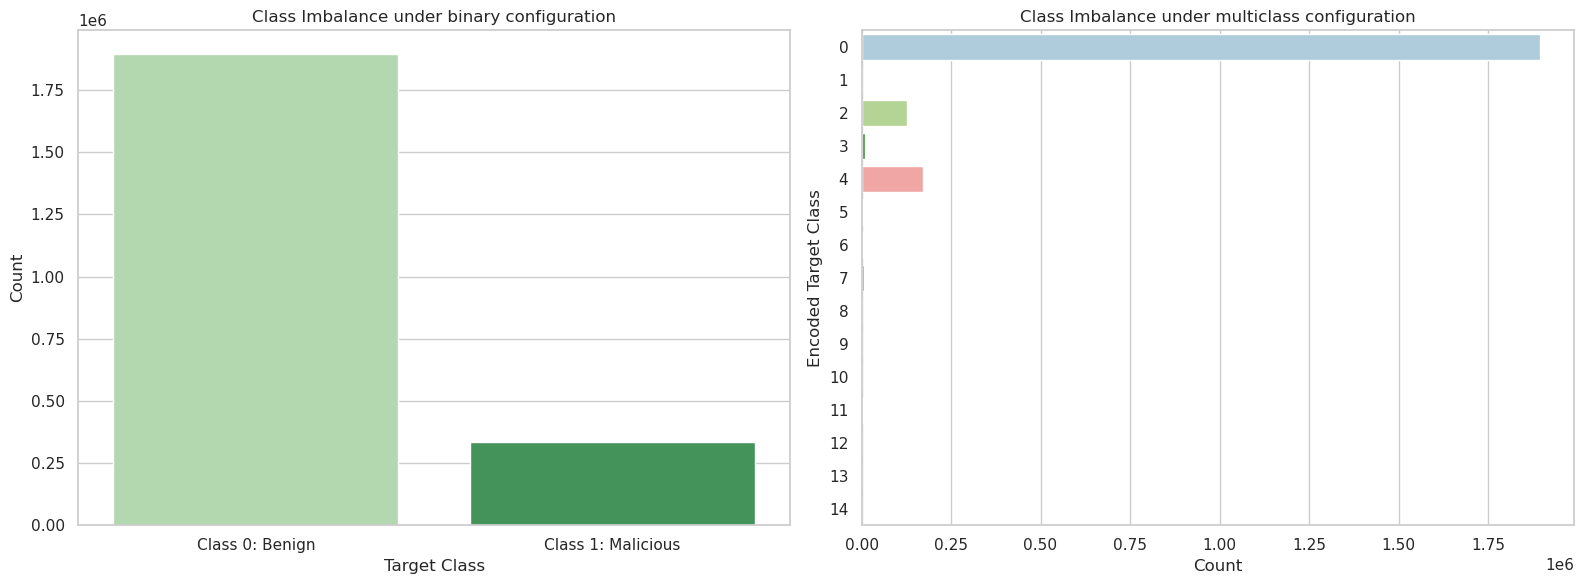

Class Imbalance under binary configuration:

Class 0 ratio: 84.92%
Class 1 ratio: 15.08%

Class Imbalance under multiclass configuration:

Class 0  ratio: 84.9229%
Class 4  ratio: 7.7447%
Class 2  ratio: 5.7359%
Class 3  ratio: 0.4609%
Class 7  ratio: 0.2657%
Class 6  ratio: 0.2413%
Class 5  ratio: 0.2342%
Class 11 ratio: 0.1442%
Class 10 ratio: 0.0876%
Class 12 ratio: 0.0659%
Class 1  ratio: 0.0644%
Class 14 ratio: 0.0292%
Class 9  ratio: 0.0016%
Class 13 ratio: 0.0009%
Class 8  ratio: 0.0005%


In [11]:
# 1.2.4 - Visualize class imbalance for both configurations

# Adjusting plot styles
sns.set(style="whitegrid")

# Create a figure and axes (left and right subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting the distribution of the binary target variable y_b
sns.countplot(x=y_b, palette='Greens', ax=axs[0])
axs[0].set_title('Class Imbalance under binary configuration')
axs[0].set_xlabel('Target Class')
axs[0].set_ylabel('Count')
axs[0].set_xticks(ticks=[0, 1])
axs[0].set_xticklabels(['Class 0: Benign', 'Class 1: Malicious'])

# Plotting the distribution of the target variable y_m
sns.countplot(y=y_m, palette='Paired', ax=axs[1])
axs[1].set_title('Class Imbalance under multiclass configuration')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Encoded Target Class')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

# Calculate the count and ratio of each class for y_b
class_counts_b = y_b.value_counts()
class_ratios_b = class_counts_b / len(y_b)

# Print the ratio of each class for y_b
print("Class Imbalance under binary configuration:\n")
print(f"Class 0 ratio: {class_ratios_b[0]*100:.2f}%")
print(f"Class 1 ratio: {class_ratios_b[1]*100:.2f}%")

# Calculate the count and ratio of each class for y_m
class_counts_m = y_m.value_counts()
class_ratios_m = class_counts_m / len(y_m)

# Print the ratio of each class for y_m
print("\nClass Imbalance under multiclass configuration:\n")
for label, ratio in class_ratios_m.items():
    if label < 10:
        print(f"Class {label}  ratio: {ratio*100:.4f}%")
    else:
        print(f"Class {label} ratio: {ratio*100:.4f}%")

> ### Minimum baseline accuracy of 84.92%
Understanding the class distribution is crucial for evaluating the performance of machine learning or deep learning models. In this dataset, the majority class (Class 0) comprises approximately 84.92% of the samples, while the minority class (Class 1) constitutes 15.08%. This implies that **a naive model that always predicts the majority class would achieve a minimum baseline accuracy of 84.92%**. The same holds for multi-class configuration, since all attack classes can be considered as minority classes. Therefore, any machine learning or deep learning model developed for this dataset, under both configurations, should aim to outperform this baseline accuracy to demonstrate meaningful predictive power.

# 1.3 Splitting the Dataset

In the typical deep learning workflow, it is advisable to partition the dataset into training, validation, and test sets. This division serves several purposes, including assessing model performance, tuning hyperparameters, and evaluating generalization on unseen data.

In [12]:
# 1.3.1 - Defining a fuction in order to extract the train, validation and test sets

def extractAllSets(X, y, p_train, p_val, p_test, random_state=seed_pi, shuffle=True):
    ''''
    Splits a given pandas dataframe X (features) into three subsets:X_train, X_val and X_test. 
    Also splits a given pandas series y (target) to y_train, y_val and y_test respectively. 
    Fractional ratios are provided by the user, as percentages, namely: p_train, p_valid, p_test. 
    These inputs describe the percentage of the extracted sets in reference with the inputs X and y. 
    The final sets are extracted by executing method train_test_split() twice.

    Parameters
    ----------
    X: pandas Dataframe
    y: pandas Series
    p_train, p_val, p_test  : float
    random_state : integer
    shuffle: (boolean) Enables shuffling the dataset
    
    The values should be expressed as float fractions and  should  sum to 1.0.
    The parameter of random_state ensures reproducibility.
    
    Returns
    -------
    X_train, X_val, X_test :
        Dataframes (features) containing the three splits.
    y_train, y_val, y_test  :
        Series (targets) containig the three splits
    '''
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y,                
                                                        stratify=y,
                                                        test_size=(1.0 - p_train),
                                                        random_state=random_state,
                                                        shuffle=shuffle)  # Enable/disable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution 
    # of chareacteristics in targets
    
    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
                                                      test_size=fraction,
                                                      random_state=random_state,
                                                      shuffle=shuffle)  # Enable/disable shuffling
    # Note that we use the same random_state twice for reproducibility
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# 1.3.2 - Extract all sets with percentages: 75-10-15 (%) for both configurations

X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = extractAllSets(
        X,y_b,0.75,0.10,0.15,seed_pi)
X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m = extractAllSets(
        X,y_m,0.75,0.10,0.15,seed_pi)

# Organize all sets in list format
original_data_b = [X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b]
# Organize all sets in list format
original_data_m = [X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m]

# 1.4 Feature Selection with XGBoost

In [14]:
# 1.4.1 - Get Feature Importances

def get_feature_importances(original_data, clf_params, printing=False):
    # Extract original data
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    
    # Create XGBoost classifier instance
    xgb_clf = XGBClassifier(**clf_params)

    # Train the classifier
    xgb_clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # Get feature importances
    feature_importances = xgb_clf.feature_importances_
    
    # Default option is False. This segment exists for debugging purposes.
    if printing:
        # Determine the maximum length of feature names
        max_feature_name_length = max(len(name) for name in X_train.columns)
        print(f"{'Feature Name':<{max_feature_name_length}}\tImportance")
        for name, importance in zip(X_train.columns, 
                                    feature_importances):
            print(f"{name:<{max_feature_name_length}}\t{importance*100:.2f}%")               
    
    return feature_importances

In [15]:
# 1.4.2 - Select Features by threshold

def select_features_by_threshold(original_data, clf_params, threshold=0.01, printing=False):
    # Concatenate training and validation data for feature selection
    X_train, X_val, X_test, y_train, y_val, y_test = original_data
    
    # Get feature importances
    feature_importances = get_feature_importances(original_data, clf_params)
    
    # Get feature names
    feature_names = X_train.columns
    
    # Select features based on threshold
    selected_features = np.where(feature_importances > threshold)[0]
    
    # Create a list of tuples containing feature names & importances
    feature_tuples = [(name, importance) for name, importance in 
        zip(feature_names[selected_features], feature_importances[selected_features])]
    
    # Sort selected features by importance in descending order
    sorted_feature_tuples = sorted(feature_tuples, key=lambda x: x[1], reverse=True)
    
    # Extract sorted feature names and importances
    sorted_feature_names = [tup[0] for tup in sorted_feature_tuples]
    sorted_feature_importances = [tup[1] for tup in sorted_feature_tuples]
    
    # Subset the original data with selected features
    X_train_selected = X_train.loc[:, sorted_feature_names]
    X_val_selected   = X_val.loc[:, sorted_feature_names]
    X_test_selected  = X_test.loc[:, sorted_feature_names]

    # Print the number of selected features
    print(f"The number of selected features are: {len(sorted_feature_names)}",'\n')

    # Print selected feature names and importances if printing is True
    if printing:
        # For an explanation of the following lines, look in the code cell above
        max_feature_name_length = max(len(name) for name in sorted_feature_names)
        print(f"{'Feature Name':<{max_feature_name_length}}\tImportance\n")
        for name, importance in sorted_feature_tuples:
            print(f"{name:<{max_feature_name_length}}\t{importance*100:.2f}%")
    
    return X_train_selected, X_val_selected, X_test_selected, sorted_feature_tuples

In [16]:
# 1.4.3 - Feature Selection

""" Binary Configuration: """

# Define classifier's parameters
clf_params_b = dict(
    objective='binary:logistic',   # Binary classification
    n_estimators=50,               # Maximum number of estimators (epochs)
    eval_metric='logloss',         # Logarithmic loss
    max_depth=3,                   # Maximum depth of a tree
    learning_rate=0.1,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    reg_alpha=0.1,                 # L1 regularization term on weights
    early_stopping_rounds=10,      # Early stopping rounds
    random_state=seed_pi)          # Set random state for reproducibility

print("Under Binary Configuration:\n")
X_train_selected_b,X_val_selected_b,X_test_selected_b,feature_tuples_b=select_features_by_threshold(
    original_data_b, clf_params = clf_params_b, threshold=0.01, printing=True)

# Leave space:
print("")

""" Multi-class Configuration: """

num_classes = len(class_counts_m)

# Define classifier's parameters
clf_params_m = dict(
    objective='multi:softmax',     # Multiclass classification
    num_class=num_classes,         # Number of classes in your dataset
    n_estimators=50,               # Maximum number of estimators (epochs)
    eval_metric='mlogloss',        # Multiclass logarithmic loss
    max_depth=3,                   # Maximum depth of a tree
    learning_rate=0.1,             # Learning rate
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    reg_alpha=0.1,                 # L1 regularization term on weights
    early_stopping_rounds=10,      # Early stopping rounds
    random_state=seed_pi)          # Set random state for reproducibility

print("Under Multi-class Configuration:\n")
X_train_selected_m,X_val_selected_m,X_test_selected_m,feature_tuples_m=select_features_by_threshold(
    original_data_m, clf_params = clf_params_m, threshold=0.01, printing=True)

Under Binary Configuration:

The number of selected features are: 20 

Feature Name          	Importance

Bwd Packet Length Std 	25.15%
Packet Length Std     	12.62%
Bwd Packet Length Mean	8.67%
Total Fwd Packets     	7.36%
Fwd Packet Length Min 	4.90%
Fwd IAT Total         	4.25%
Fwd Packet Length Std 	4.02%
Bwd Packets/s         	3.09%
Avg Bwd Segment Size  	3.00%
Avg Packet Size       	2.44%
Fwd Header Length     	2.06%
Fwd Packet Length Max 	2.04%
Fwd IAT Mean          	2.03%
Fwd Act Data Packets  	1.57%
Fwd IAT Std           	1.47%
Bwd Packet Length Min 	1.44%
FIN Flag Count        	1.33%
Fwd IAT Max           	1.21%
Active Max            	1.08%
Flow Duration         	1.05%

Under Multi-class Configuration:

The number of selected features are: 20 

Feature Name            	Importance

Idle Mean               	18.29%
Bwd Packet Length Std   	12.59%
Avg Bwd Segment Size    	11.85%
Subflow Bwd Packets     	4.75%
Fwd Act Data Packets    	4.03%
Subflow Fwd Bytes       	4.01%
Bwd Packe

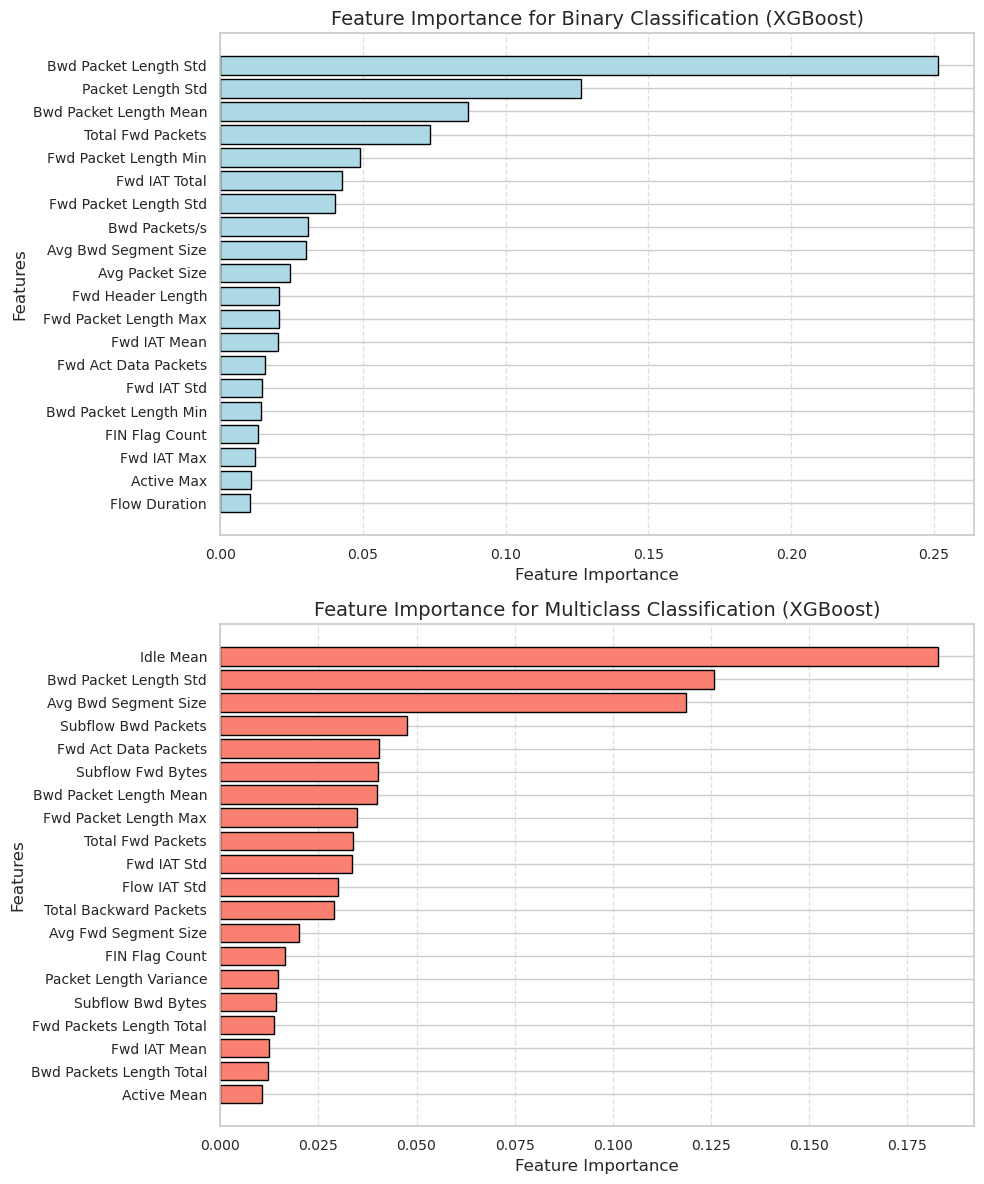

In [17]:
import matplotlib.pyplot as plt

# Define figure with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Extract feature names and their corresponding significance scores for binary configuration
feature_names_b = [tup[0] for tup in feature_tuples_b]
significance_scores_b = [tup[1] for tup in feature_tuples_b]

# Plot for binary configuration (using a soft blue color)
axs[0].barh(feature_names_b, significance_scores_b, color='lightblue', edgecolor='black')
axs[0].set_xlabel('Feature Importance', fontsize=12)
axs[0].set_ylabel('Features', fontsize=12)
axs[0].set_title("Feature Importance for Binary Classification (XGBoost)", fontsize=14)
axs[0].invert_yaxis()
axs[0].grid(True, axis='x', linestyle='--', alpha=0.6)
axs[0].tick_params(axis='both', which='major', labelsize=10)

# Extract feature names and their corresponding significance scores for multi-class configuration
feature_names_m = [tup[0] for tup in feature_tuples_m]
significance_scores_m = [tup[1] for tup in feature_tuples_m]

# Plot for multi-class configuration (using a warm red color)
axs[1].barh(feature_names_m, significance_scores_m, color='salmon', edgecolor='black')
axs[1].set_xlabel('Feature Importance', fontsize=12)
axs[1].set_ylabel('Features', fontsize=12)
axs[1].set_title("Feature Importance for Multiclass Classification (XGBoost)", fontsize=14)
axs[1].invert_yaxis()
axs[1].grid(True, axis='x', linestyle='--', alpha=0.6)
axs[1].tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


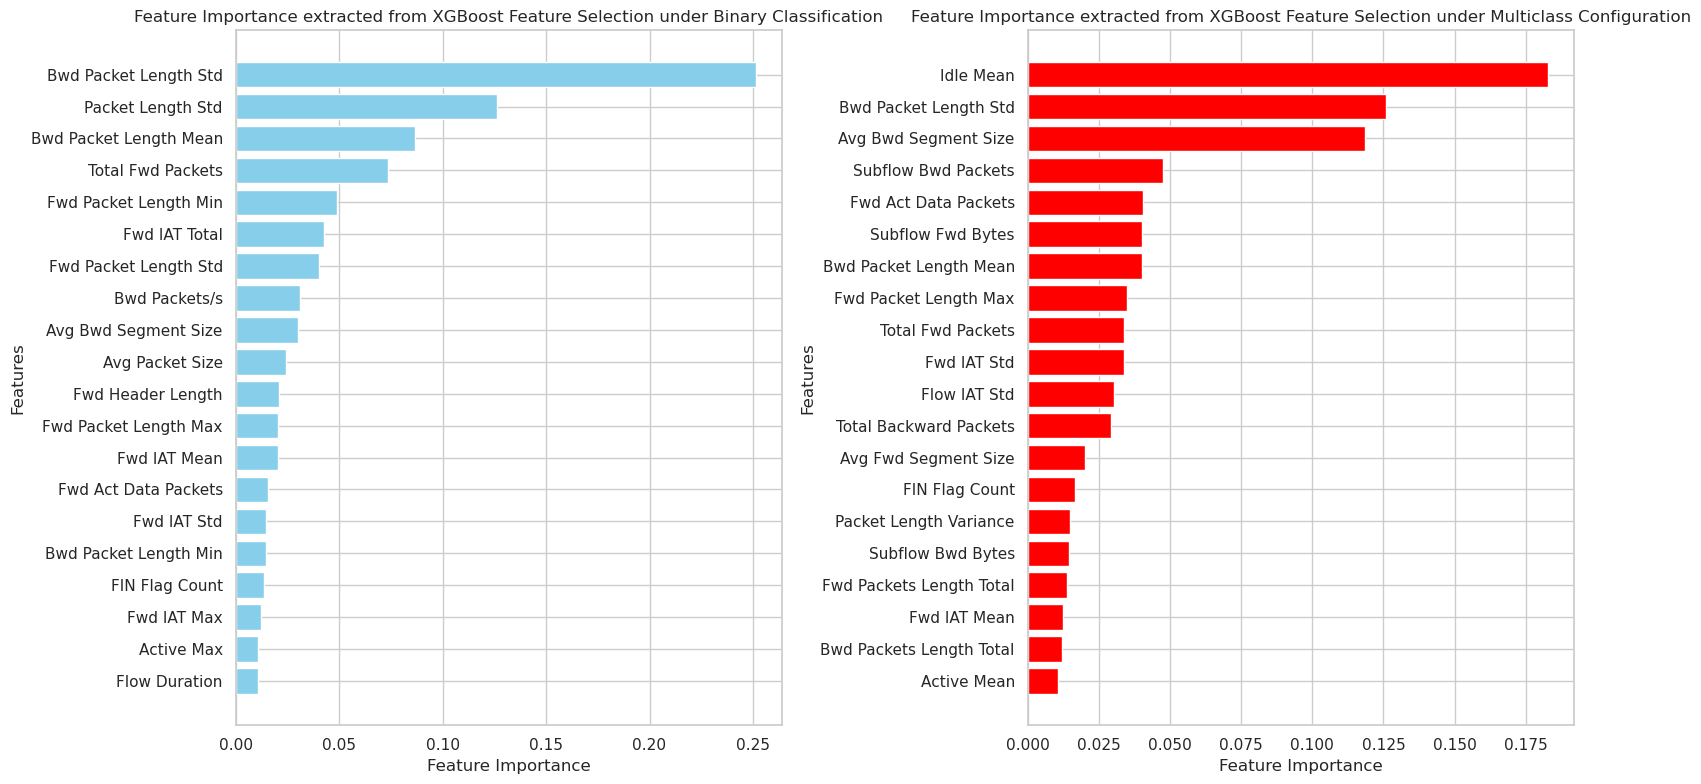

In [18]:
# 1.4.4 - Plotting Feature Importance for both configurations

# Define figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Extracting feature names and their corresponding significance scores from feature_tuples_b
feature_names_b       = [tup[0] for tup in feature_tuples_b]
significance_scores_b = [tup[1] for tup in feature_tuples_b]

# Plot for binary configuration
axs[0].barh(feature_names_b, significance_scores_b, color='skyblue')
axs[0].set_xlabel('Feature Importance')
axs[0].set_ylabel('Features')
axs[0].set_title("Feature Importance extracted from XGBoost Feature Selection" +
                  " under Binary Classification")
axs[0].invert_yaxis()


# Extracting feature names and their corresponding significance scores from feature_tuples_b
feature_names_m       = [tup[0] for tup in feature_tuples_m]
significance_scores_m = [tup[1] for tup in feature_tuples_m]

# Plot for multi-class configuration
axs[1].barh(feature_names_m, significance_scores_m, color='red')
axs[1].set_xlabel('Feature Importance')
axs[1].set_ylabel('Features')
axs[1].set_title("Feature Importance extracted from XGBoost Feature Selection" + 
                 " under Multiclass Configuration")
axs[1].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()

In [19]:
# 1.4.5 - Find the elements present in feature_names_b but not in feature_names_m
unique_in_b = set(feature_names_b) - set(feature_names_m)
# Find the elements present in feature_names_m but not in feature_names_b
unique_in_m = set(feature_names_m) - set(feature_names_b)

print("Unique elements not shared between 'feature_names_b' and 'feature_names_m':\n")
print("Binary configuration:")
print(unique_in_b)
print("")
print("Multi-class configuration:")
print(unique_in_m)

Unique elements not shared between 'feature_names_b' and 'feature_names_m':

Binary configuration:
{'Bwd Packets/s', 'Fwd Packet Length Min', 'Fwd IAT Max', 'Bwd Packet Length Min', 'Fwd IAT Total', 'Packet Length Std', 'Fwd Header Length', 'Active Max', 'Flow Duration', 'Avg Packet Size', 'Fwd Packet Length Std'}

Multi-class configuration:
{'Idle Mean', 'Subflow Fwd Bytes', 'Packet Length Variance', 'Avg Fwd Segment Size', 'Subflow Bwd Bytes', 'Bwd Packets Length Total', 'Total Backward Packets', 'Fwd Packets Length Total', 'Flow IAT Std', 'Active Mean', 'Subflow Bwd Packets'}


*We notice that the two configurations do not share all features!*

### Summary - Feature Selection
Out of the initial 77 features, only 20 demonstrate statistical importance exceeding 1%. For the sake of **readability**, the unselected features will not be presented in this notebook. The pipeline will proceed exclusively with the **selected features only**, since this procedure serves additionally as reduction of dimensions.

# 1.5 Feature Engineering under Binary Configuration

## 1.5.1 New Features

In [20]:
# 1.5.1.1 - Combined Feature Importance

def create_new_features_1(feature_tuples):
    """
    This function creates a combined feature score based on weighted importance from feature_tuples, 
    after applying normalization to the dataframe.

    Args:
      feature_tuples (list): A list of tuples where each tuple contains the feature name and 
      its importance weight.

    Returns:
      Pandas dataframes with the original features and the newly created scores.
    """
    # Normalize the dataframes
    normalizer = Normalizer()
    df_normalized_train = pd.DataFrame(normalizer.fit_transform(X_train_selected_b), 
                                       columns=X_train_selected_b.columns)
    df_normalized_val   = pd.DataFrame(normalizer.transform(X_val_selected_b), 
                                       columns=X_val_selected_b.columns)
    df_normalized_test  = pd.DataFrame(normalizer.transform(X_test_selected_b), 
                                       columns=X_test_selected_b.columns)

    # Extract feature names and weights from tuples
    feature_names, weights = zip(*feature_tuples)
    
    """
    Weights could be calculated differently, e.g. via Mutual Importance. Note: this practice is 
    computationally expensive!
    
    # Concatenate df_scaled_train and df_scaled_val into a dataframe named df_scaled_train_val 
    # (with y_train_val as corresponding). See code cell 1.4.1 why test set is excluded (data leakage)
    df_scaled_train_val = pd.concat([df_scaled_train, df_scaled_val])
    y_train_val = pd.concat([y_train, y_val])

    # Compute mutual information for classification
    mi = mutual_info_classif(df_scaled_train_val, y_train_val)
    """

#     # Check if all features in weights are present in the dataframe
#     if not set(feature_names).issubset(df.columns):
#         raise ValueError("Not all features from weights are present in the dataframe")

    # Calculate weighted sum (on normalized dataframes) based on feature importance
    df_normalized_train["Combined_Importance_Score"] = df_normalized_train[list(feature_names)].dot(weights)
    df_normalized_val["Combined_Importance_Score"]   = df_normalized_val[list(feature_names)].dot(weights)
    df_normalized_test["Combined_Importance_Score"]  = df_normalized_test[list(feature_names)].dot(weights)
    
    """
    # Calculate weighted sum (on scaled dataframes) based on mutual information
    df_normalized_train["Combined_MI_Score"] = df_normalized_train[list(feature_names)].dot(mi)
    df_normalized_val["Combined_MI_Score"]   = df_normalized_val[list(feature_names)].dot(mi)
    df_normalized_test["Combined_MI_Score"]  = df_normalized_test[list(feature_names)].dot(mi)
    """

   # Return the normalized dataframes
    return df_normalized_train, df_normalized_val, df_normalized_test

In [21]:
# 1.5.1.1.+ - Binary Implementation

# Check if feature_tuples exists
if 'feature_tuples_b' not in globals():
    # Call the function to create feature_tuples
    _, feature_tuples_b = select_features_by_threshold(original_data_b, clf_params=clf_params_b)

# Apply the function to training, validation, and test data
X_train_selected_b, X_val_selected_b, X_test_selected_b = create_new_features_1(feature_tuples_b)

**2. Feature Ratio and Differences:**

In [22]:
# 1.5.1.2 - Feature Ratio and Differences

def create_new_features_2(df):
    """
    This function creates new features based on Feature Ratio and Differences.

    Args:
        df: A pandas dataframe containing the selected features.

    Returns:
        A pandas dataframe with the original features and the newly created features.
    """
    # Standardized Difference: Packet Length Variation
    df["Packet_Length_Std_Diff"] = df["Bwd Packet Length Std"] - df["Packet Length Std"]
    
    # Length Difference
    df["Total_Packets_Diff"] = df["Total Fwd Packets"] - X["Total Backward Packets"]

    return df

In [23]:
# 1.5.1.2.+ - Binary Implementation

# Apply the function to training, validation, and test data
X_train_selected_b = create_new_features_2(X_train_selected_b)
X_val_selected_b   = create_new_features_2(X_val_selected_b)
X_test_selected_b  = create_new_features_2(X_test_selected_b)

**3. Interaction Feature:**

In [24]:
# 1.5.1.3 - Feature Percentages

def create_new_features_3(df):
    """
    This function creates new features based on interaction of features.

    Args:
      df: A pandas dataframe containing the selected features.

    Returns:
      A pandas dataframe with the original features and the newly created features.
    """
    # Interaction features: Product of features
    df["Bwd_Fwd_Product"] = df["Bwd Packets/s"] * df["Flow Duration"]
    
    return df

In [25]:
# 1.5.1.3.+ - Binary Implementation

# Apply the function to training, validation, and test data
X_train_selected_b = create_new_features_3(X_train_selected_b)
X_val_selected_b   = create_new_features_3(X_val_selected_b)
X_test_selected_b  = create_new_features_3(X_test_selected_b)

## 1.5.2 Secondary Evaluation
During this phase, we conduct a secondary evaluation to study the impact of the recently generated features. We employ the same feature selection approach using XGBoost as outlined in section 1.4.

In [26]:
# 1.5.2.1 - Conduct evaluation of the new features

# Arrange selected data as a list
selected_data_b = [X_train_selected_b, X_val_selected_b, X_test_selected_b,
                   y_train_b, y_val_b, y_test_b]

# Extract features
X_train_final_b, X_val_final_b, X_test_final_b, feature_tuples_final_b = select_features_by_threshold(
               selected_data_b, clf_params=clf_params_b, threshold=0.01, printing=True)

# Arrange final data as a list
final_data_b = [X_train_final_b, X_val_final_b, X_test_final_b, y_train_b, y_val_b, y_test_b]

The number of selected features are: 20 

Feature Name          	Importance

Packet_Length_Std_Diff	20.87%
Fwd IAT Max           	11.13%
Bwd_Fwd_Product       	9.08%
Bwd Packet Length Min 	8.35%
Fwd IAT Total         	6.75%
Total Fwd Packets     	5.10%
Flow Duration         	4.42%
Avg Bwd Segment Size  	3.80%
Fwd Packet Length Max 	3.77%
Bwd Packets/s         	3.64%
Bwd Packet Length Std 	3.18%
Fwd Packet Length Std 	2.99%
Avg Packet Size       	2.92%
Bwd Packet Length Mean	2.35%
Active Max            	2.25%
FIN Flag Count        	2.23%
Fwd IAT Std           	1.99%
Packet Length Std     	1.44%
Fwd IAT Mean          	1.24%
Fwd Header Length     	1.19%


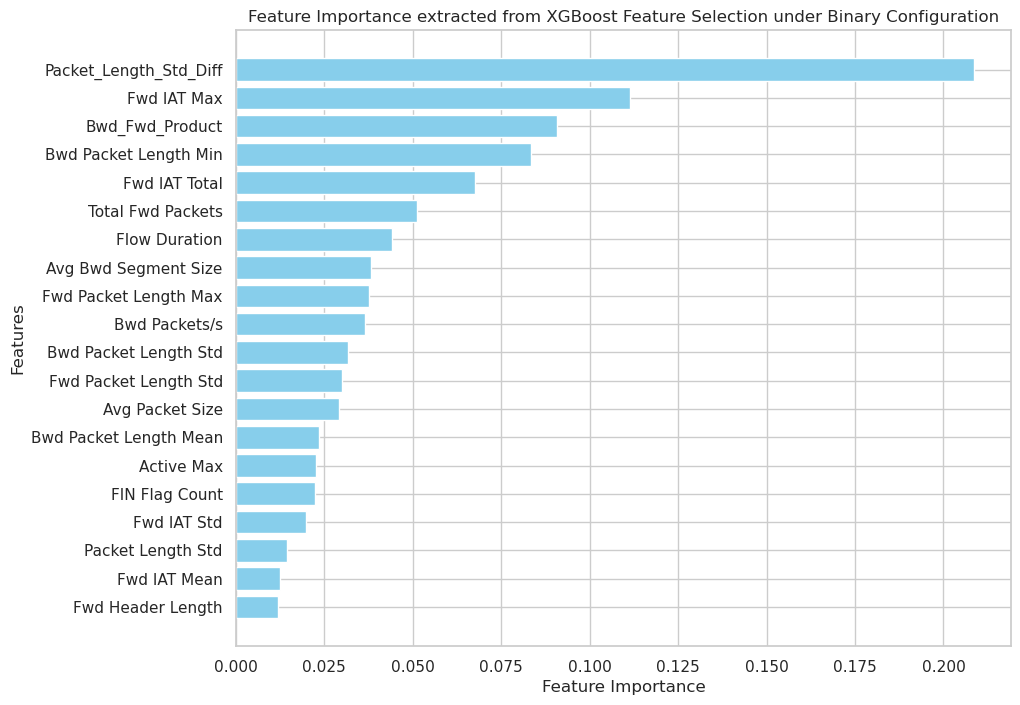

In [27]:
# 1.5.2.2 - Plotting Feature Importance

# Extracting feature names and their corresponding significance scores from feature_tuples_final
feature_names_final_b       = [tup[0] for tup in feature_tuples_final_b]
significance_scores_final_b = [tup[1] for tup in feature_tuples_final_b]

# Plotting the horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names_final_b, significance_scores_final_b, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance extracted from XGBoost Feature Selection'+
          ' under Binary Configuration')
# Invert y-axis to display features from top to bottom
plt.gca().invert_yaxis()  
plt.show()

### Conclusion - Feature Engineering
In summary, the feature engineering procedure concludes successfully, since the two out of the four new developed features are selected from the (standard) XGBoost algorithm. Addionally, almost all initially  selected features are maintained, with the exception of features `Fwd Act Data Packets` and `Fwd Packet Length Min`, substituded from `Bwd_Fwd_Product` and `Packet_Length_Std_Diff`. In summary there are 20 features for the binary configuration.

# 1.6 Exploratory Data Analysis

In [28]:
pip install -q ydata_profiling

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [29]:
# 1.6 - Automatic EDA

if tf.config.list_physical_devices('GPU'):
    # print("GPU is available")
    """ Attention! Importing the following module while operating on GPU creates a bug."""
    """ from ydata_profiling import ProfileReport """
    """ Therefore, the report must be created while on CPU and saved, so under GPU is simply loaded. """
    # Load the HTML report in a GPU session
    
    """ Binary Configuration"""
    report_path_b = "cic_ids_2017_b.html"
    if os.path.exists(report_path_b):
        #print("File exists")
        
        # Load the HTML report in a GPU session
        report_path_b = "cic_ids_2017_b.html"
        # Display the report using an iframe
        display(HTML(filename=report_path_b))
    else:
        print("File not found")
        
    """ Multi-class Configuration"""
    report_path_m = "cic_ids_2017_m.html"
    if os.path.exists(report_path_m):
        #print("File exists")
        
        # Load the HTML report in a GPU session
        report_path_m = "cic_ids_2017_m.html"
        # Display the report using an iframe
        display(HTML(filename=report_path_m))
    else:
        print("File not found")
else:
    # print("CPU is being used")
    
    # for automatic EDA
    from ydata_profiling import ProfileReport
    
    """ Binary Configuration """
    # Concatenate 'X_train_final', 'X_val_final' and 'X_test_final' into a dataframe named X_final 
    X_final_b = pd.concat([X_train_final_b, X_val_final_b, X_test_final_b])

    # Initiate 'Profile Report' object
    report_b = ProfileReport(X_final_b,
            minimal=True,
            title="CIC-IDS-2017 Binary Configuration under Feature Selection & Engineering",
            dataset={
            "description": "Intrusion Detection Evaluation Dataset containing " + 
                "labeled network traffic for training and testing intrusion detection systems.",
            "author": "University of New Brunswick",
            "copyright_holder": "University of New Brunswick",
            "copyright_year": 2017,
            "url": "<https://www.unb.ca/cic/datasets/ids-2017.html>"})
    # Save to file in Kaggle working directory
    report_path_b = "cic_ids_2017_b.html"
    report_b.to_file(report_path_b)
    # Print the path where the report is saved
    print("Report saved at:", report_path_b)
    # Print / Plot
    report_b.to_notebook_iframe()
    #report_b.to_widgets()
    # Leave space:
    print("")
    
    """ Multiclass Configuration"""
    # Concatenate 'X_train_selected_m', 'X_val_selected_m' and 'X_test_selected_m'
    # into a dataframe named X_selected_m 
    X_selected_m = pd.concat([X_train_selected_m, X_val_selected_m, X_test_selected_m])

    # Initiate 'Profile Report' object
    report_m = ProfileReport(X_selected_m,
            minimal=True,
            title="CIC-IDS-2017 Multiclass Configuration",
            dataset={
            "description": "Intrusion Detection Evaluation Dataset containing " + 
                "labeled network traffic for training and testing intrusion detection systems.",
            "author": "University of New Brunswick",
            "copyright_holder": "University of New Brunswick",
            "copyright_year": 2017,
            "url": "<https://www.unb.ca/cic/datasets/ids-2017.html>"})
    # Save to file in Kaggle working directory
    report_path_m = "cic_ids_2017_m.html"
    report_m.to_file(report_path_m)
    # Print the path where the report is saved
    print("Report saved at:", report_path_m)
    # Print / Plot
    report_m.to_notebook_iframe()
    #report_m.to_widgets()

2024-12-31 14:52:52.072474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-31 14:52:52.082873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-31 14:52:52.084318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 1.8 SMOTE: Synthetic Minority Oversampling Technique for Imbalanced Datasets

In [30]:
# 1.8 - Conduct SMOTE

# Sampling strategy '0.5' corresponds to binary classification
smote = SMOTE(sampling_strategy = 0.5, random_state=seed_pi)
X_train_final_b, y_train_b = smote.fit_resample(X_train_final_b, y_train_b)

# Arrange processed data as a list - Binary Configuration
processed_data_b    = [X_train_final_b, X_val_final_b, X_test_final_b, y_train_b, y_val_b, y_test_b]
# Arrange processed data as a list - Multiclass Configuration
processed_data_m = [X_train_selected_m,X_val_selected_m,X_test_selected_m,y_train_m,y_val_m,y_test_m]

# 2. Binary Classification Using MLPs for Intrusion Detection

In [31]:
# 2.0 - Delete variables to free memory space for traininig

del df_data_1, df_data_2, df_data_3, df_data_4, df_data_5, df_data_6, df_data_7, df_data_8
""" Binary Configuration """
del original_data_b, X_train_b, X_val_b, X_test_b
del selected_data_b, X_train_selected_b, X_val_selected_b, X_test_selected_b
# del final_data_b, X_train_final_b, X_val_final_b, X_test_final_b
""" Multiclass Configuration """
del original_data_m, X_train_m, X_val_m, X_test_m
# del selected_data_m, X_train_selected_m, X_val_selected_m, X_test_selected_m

In [32]:
# 2.0 - Load the trained models

# Load the saved models for efficient workflows
#model_1_b = load_model('model_1_b.h5')
#model_2_b = load_model('model_2_b.h5')
#model_3_b = load_model('model_3_b.h5')
#model_4_b = load_model('model_4_b.h5')
#model_5_b = load_model('model_5_b.h5')

# # Arrange the models as a list
# models_b = [model_1_b, model_2_b, model_3_b, model_4_b, model_5_b]
# # Extract summary for models
# _, _, _, _, _ = [model.summary() for model in models_b]

In [33]:
# 2.1 - Defining the model architectures

# Renaming the scaled data:
[X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b] = processed_data_b

# Number of units in the Input layer
input_shape = X_train_b.shape[1]

# Binary model: model_1_b - The "minimal" architecture
model_1_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(8, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_2_b - An intermediate architecture
model_2_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_3_b - An intermediate architecture
model_3_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,  activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_4_b - An intermediate architecture
model_4_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(128, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

# Binary model: model_5_b - The "maximal" architecture
model_5_b = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation='tanh',    kernel_initializer=GlorotUniform()),
    Dense(128, activation='selu',    kernel_initializer=HeUniform()),
    Dense(64,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(32,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(16,  activation='selu',    kernel_initializer=HeUniform()),
    Dense(8,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(4,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(2,   activation='selu',    kernel_initializer=HeUniform()),
    Dense(1,   activation='sigmoid', kernel_initializer=GlorotUniform())])

models_b = [model_1_b, model_2_b, model_3_b, model_4_b, model_5_b]
# Extract summary for models
_, _, _, _, _ = [model.summary() for model in models_b]
# Extract the number of parameters for each model
num_params_b  = [model.count_params() for model in models_b]

2024-12-31 14:53:01.587807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-31 14:53:01.589483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-31 14:53:01.590893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 168       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 217 (868.00 Byte)
Trainable params: 217 (868.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

In [34]:
# 2.2 - Defining parameters for the Training Sessions under Binary configuration

# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,               # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_b = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='binary_crossentropy',# Binary crossentropy corresponds to binary Configuration 
    metrics=['accuracy'])      # montitor accuracy during training

In [35]:
# 2.2.1 - Training Session for `model_1_b`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_1_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_1_b = model_1_b.fit(**fitting_params_b)

2024-12-31 14:53:04.149905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-31 14:53:04.243836: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa76790cce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-31 14:53:04.243888: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 7g.40gb, Compute Capability 8.0
2024-12-31 14:53:04.248877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-31 14:53:04.265726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-12-31 14:53:04.316009: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-31 14:5

Restoring model weights from the end of the best epoch: 16.
Epoch 24: early stopping


In [36]:
# 2.2.2 - Training Session for `model_2_b`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_2_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_2_b = model_2_b.fit(**fitting_params_b)

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping


In [37]:
# 2.2.3 - Training Session for `model_3_b`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_3_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_3_b = model_3_b.fit(**fitting_params_b)

Restoring model weights from the end of the best epoch: 12.
Epoch 20: early stopping


In [38]:
# 2.2.4 - Training Session for `model_4_b`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_4_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_4_b = model_4_b.fit(**fitting_params_b)

Restoring model weights from the end of the best epoch: 22.
Epoch 30: early stopping


In [39]:
# 2.2.5 - Training Session for `model_5_b`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metrics
model_5_b.compile(**compilation_params_b) 

# Parameters of the training session
fitting_params_b = dict(x=X_train_b, y=y_train_b, validation_data=(X_val_b, y_val_b),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_5_b = model_5_b.fit(**fitting_params_b)

Restoring model weights from the end of the best epoch: 41.
Epoch 49: early stopping


Standard model evaluation is conducted on varius metrics, namely: `accuracy`, `precision`, `recall` and `F1 score`.

In [40]:
# 2.3.1 - Standard Evaluation

def evaluate_b(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels)
    recall    = recall_score(y_test, y_pred_labels)
    f1        = f1_score(y_test, y_pred_labels)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    
    return test_loss, test_accuracy, precision, recall, f1
    
[loss_1_b, acc_1_b, prec_1_b, recall_1_b, f1_1_b] = evaluate_b(model=model_1_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_2_b, acc_2_b, prec_2_b, recall_2_b, f1_2_b] = evaluate_b(model=model_2_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_3_b, acc_3_b, prec_3_b, recall_3_b, f1_3_b] = evaluate_b(model=model_3_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_4_b, acc_4_b, prec_4_b, recall_4_b, f1_4_b] = evaluate_b(model=model_4_b, 
                                              X_test=X_test_b, y_test=y_test_b)
[loss_5_b, acc_5_b, prec_5_b, recall_5_b, f1_5_b] = evaluate_b(model=model_5_b, 
                                              X_test=X_test_b, y_test=y_test_b)

10462/10462 [==============================] - 10s 971us/step
Test Loss:      0.1412
Test Accuracy:  94.71%
Test Precision: 81.83%
Test Recall:    83.45%
Test F1 Score:  82.63%

10462/10462 [==============================] - 10s 984us/step
Test Loss:      0.1364
Test Accuracy:  95.00%
Test Precision: 82.21%
Test Recall:    85.30%
Test F1 Score:  83.72%

10462/10462 [==============================] - 11s 1ms/step
Test Loss:      0.1064
Test Accuracy:  96.18%
Test Precision: 84.49%
Test Recall:    91.44%
Test F1 Score:  87.83%

10462/10462 [==============================] - 11s 1ms/step
Test Loss:      0.0878
Test Accuracy:  96.94%
Test Precision: 86.99%
Test Recall:    93.68%
Test F1 Score:  90.21%

10462/10462 [==============================] - 11s 1ms/step
Test Loss:      0.0435
Test Accuracy:  98.72%
Test Precision: 95.39%
Test Recall:    96.18%
Test F1 Score:  95.78%



We proceed with two advanced evaluation metrics, namely False Alarm Ratio (FAR) and Attack Miss Ratio (AMR). For more details, visit this [source](https://www.kaggle.com/code/nolovelost/short-tutorial-on-multi-class-metrics#4.-Specialization:-Intrusion-Detection-System).

In [41]:
#  2.3.2 - Advanced Evaluation

def far_amr_b(model, X_test=X_test_b, y_test=y_test_b, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    # Extract predictions from the test set
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to class labels
    y_pred_labels = (y_pred > 0.5).astype(int)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Plotting parameter exists for debugging purposes
    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    # Calculate FAR:
    true_positives  = conf_matrix[0,0]
    false_positives = conf_matrix[0,1] 
    all_positives   = true_positives + false_positives
    far = false_positives / all_positives
    #Calculate AMR:
    false_negatives = conf_matrix[1,0] 
    true_negatives  = conf_matrix[1,1]
    all_negatives   = true_negatives + false_negatives
    amr = false_negatives / all_negatives
    return far, amr
    
far_1_b, amr_1_b = far_amr_b(model_1_b, plotting=False)
far_2_b, amr_2_b = far_amr_b(model_2_b, plotting=False)
far_3_b, amr_3_b = far_amr_b(model_3_b, plotting=False)
far_4_b, amr_4_b = far_amr_b(model_4_b, plotting=False)
far_5_b, amr_5_b = far_amr_b(model_5_b, plotting=False)

print("")
print(f"Model_1_b: (FAR, AMR) = ({far_1_b:.4f}, {amr_1_b:.4f})")
print(f"Model_2_b: (FAR, AMR) = ({far_2_b:.4f}, {amr_2_b:.4f})")
print(f"Model_3_b: (FAR, AMR) = ({far_3_b:.4f}, {amr_3_b:.4f})")
print(f"Model_4_b: (FAR, AMR) = ({far_4_b:.4f}, {amr_4_b:.4f})")
print(f"Model_5_b: (FAR, AMR) = ({far_5_b:.4f}, {amr_5_b:.4f})")

10462/10462 [==============================] - 11s 1ms/step

Model_1_b: (FAR, AMR) = (0.0329, 0.1655)
Model_2_b: (FAR, AMR) = (0.0328, 0.1470)
Model_3_b: (FAR, AMR) = (0.0298, 0.0856)
Model_4_b: (FAR, AMR) = (0.0249, 0.0632)
Model_5_b: (FAR, AMR) = (0.0083, 0.0382)


History for model_1_b



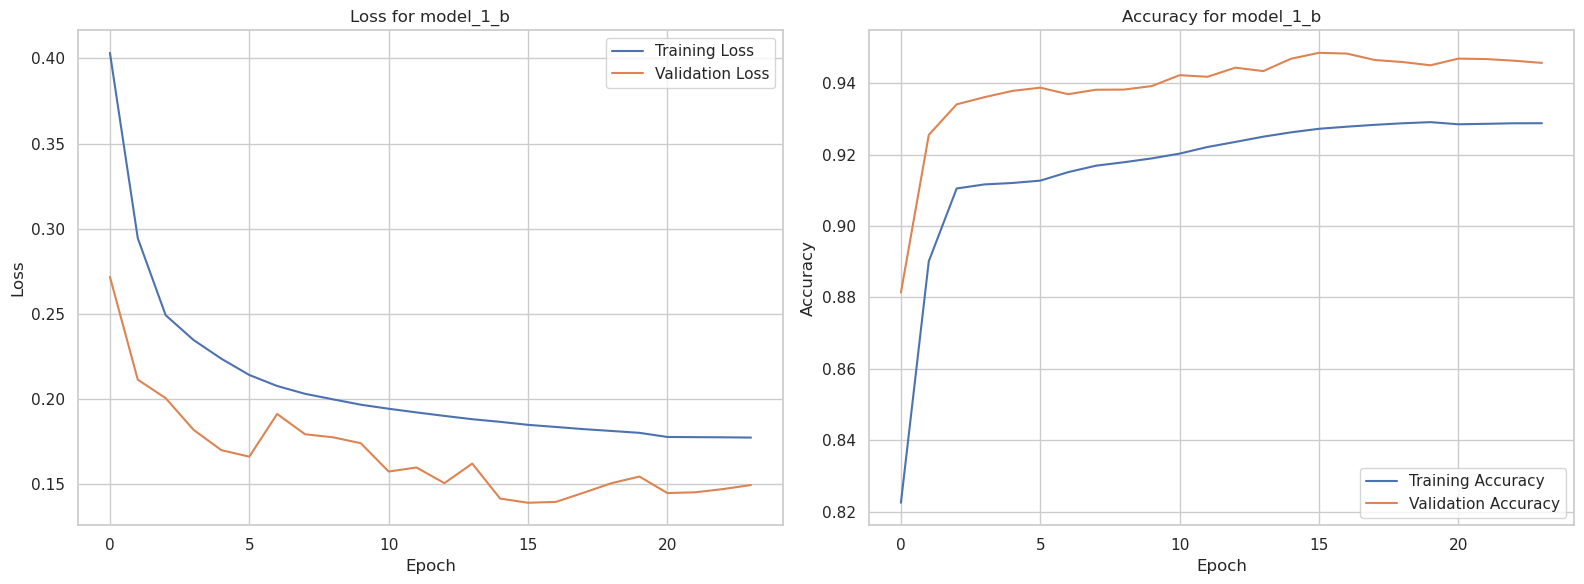


History for model_2_b



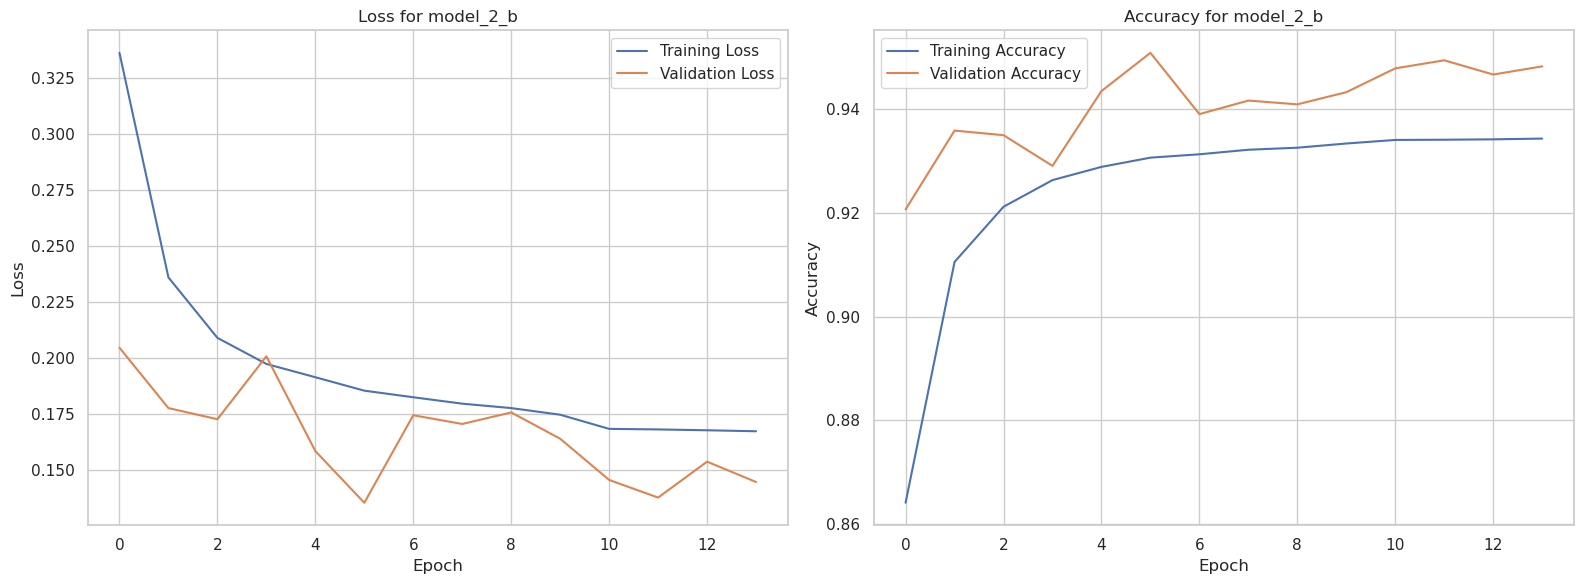


History for model_3_b



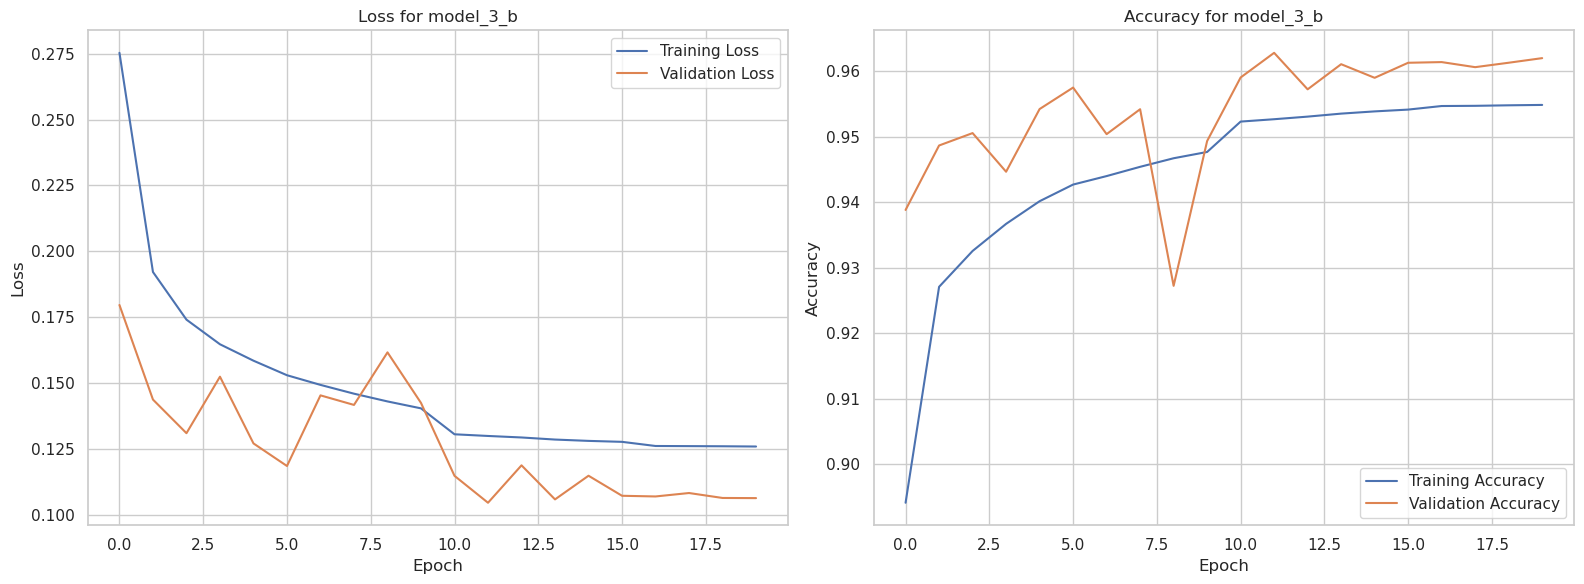


History for model_4_b



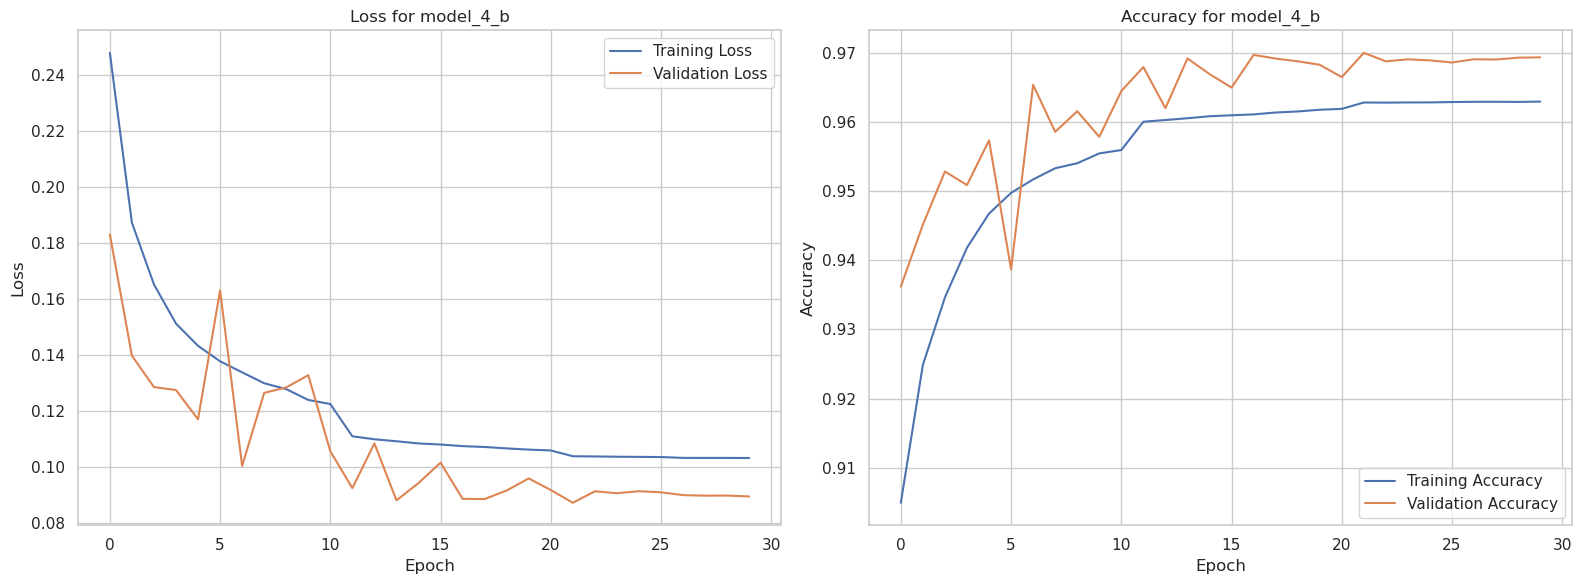


History for model_5_b



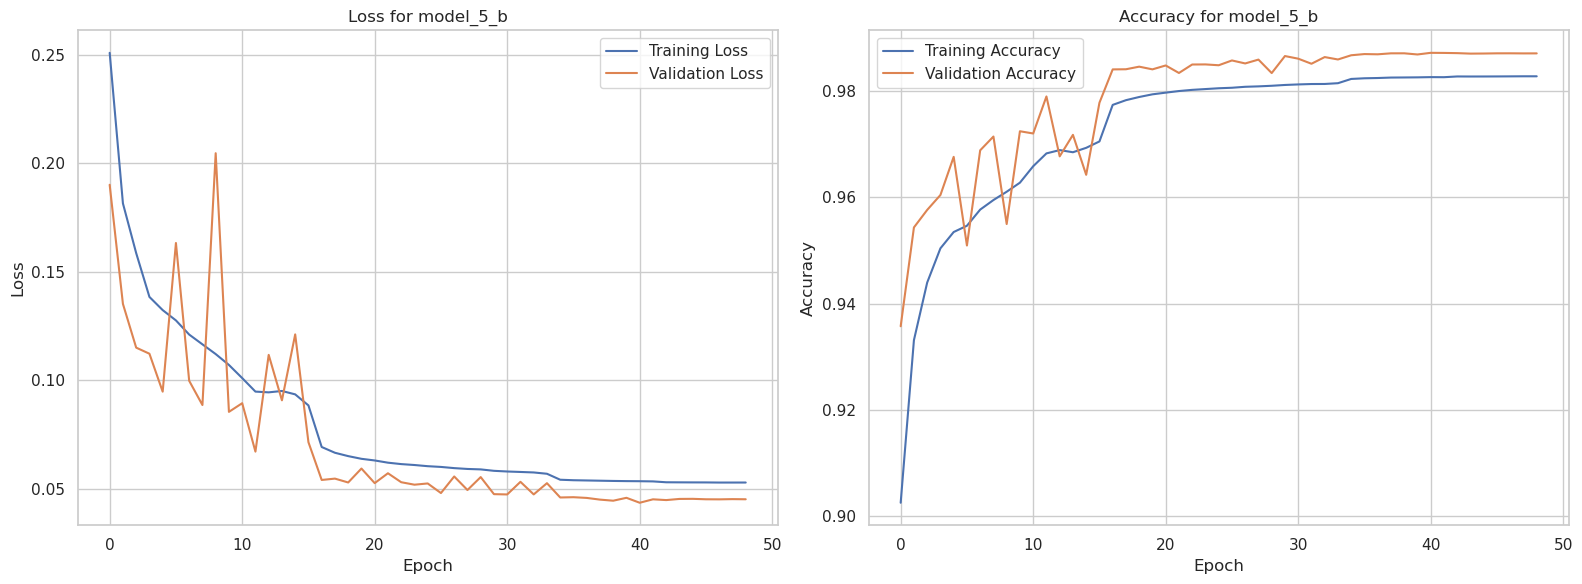

In [42]:
# 2.4.1 - Plotting history: train & validation loss and accuracy over epochs

def history_plot(history, model_name):
    """
    Plotting the loss & accuracy history of the model
    """
    
    # Suppress FutureWarnings within this function
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Extract training and validation loss/accuracy from history
        train_loss = history.history['loss']
        val_loss   = history.history['val_loss']
        train_acc  = history.history['accuracy']
        val_acc    = history.history['val_accuracy']

        # Create a figure and axes for subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

        # Plot loss curves
        sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axes[0], label='Training Loss')
        sns.lineplot(x=range(len(val_loss)),   y=val_loss, ax=axes[0], label='Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'Loss for {model_name}')
        axes[0].legend()
        axes[0].grid(True)

        # Plot accuracy curves
        sns.lineplot(x=range(len(train_acc)), y=train_acc, ax=axes[1], label='Training Accuracy')
        sns.lineplot(x=range(len(val_acc)),   y=val_acc, ax=axes[1], label='Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Accuracy for {model_name}')
        axes[1].legend()
        axes[1].grid(True)

        # Adjust layout
        plt.tight_layout()

        # Display the plot
        plt.show()

print("History for model_1_b\n")
history_plot(history_1_b, "model_1_b")
print("")
print("History for model_2_b\n")
history_plot(history_2_b, "model_2_b")
print("")
print("History for model_3_b\n")
history_plot(history_3_b, "model_3_b")
print("")
print("History for model_4_b\n")
history_plot(history_4_b, "model_4_b")
print("")
print("History for model_5_b\n")
history_plot(history_5_b, "model_5_b")

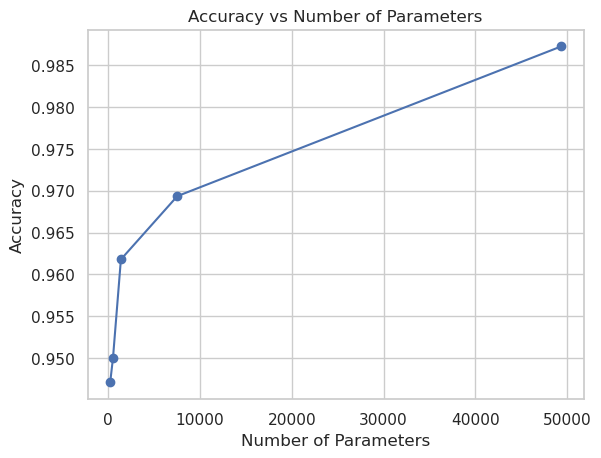

In [43]:
# 2.4.2 - Plotting accuracy vs. number of parameters trade-off

acc_b = [acc_1_b, acc_2_b, acc_3_b, acc_4_b, acc_5_b]

plt.plot(num_params_b, acc_b, marker='o')
plt.title('Accuracy vs Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Depictions of training and validation loss, as well as accuracy, (over the epochs) are provided in diagrams below.

Lastly, models will be evaluated on **latency**:

In [44]:
# 2.4.3 - Measure latency

# Measure latency
def latency(model, sample_data):
    start_time = time.time()
    model.predict(sample_data)
    end_time = time.time()
    latency = (end_time - start_time) / len(sample_data)
    return latency

# Measure & Print latency
print(f"Latency for model_1_b: {latency(model_1_b, X_test_b)*1000:.3f} ms") # Results: 0.049 m-seconds
print(f"Latency for model_2_b: {latency(model_2_b, X_test_b)*1000:.3f} ms") # Results: 0.048 m-seconds
print(f"Latency for model_3_b: {latency(model_3_b, X_test_b)*1000:.3f} ms") # Results: 0.061 m-seconds
print(f"Latency for model_4_b: {latency(model_4_b, X_test_b)*1000:.3f} ms") # Results: 0.050 m-seconds
print(f"Latency for model_5_b: {latency(model_5_b, X_test_b)*1000:.3f} ms") # Results: 0.061 m-seconds

10462/10462 [==============================] - 10s 976us/step
Latency for model_1_b: 0.038 ms
10462/10462 [==============================] - 10s 971us/step
Latency for model_2_b: 0.038 ms
10462/10462 [==============================] - 10s 978us/step
Latency for model_3_b: 0.039 ms
10462/10462 [==============================] - 10s 1000us/step
Latency for model_4_b: 0.040 ms
10462/10462 [==============================] - 11s 1ms/step
Latency for model_5_b: 0.041 ms


In [45]:
# 2.2.5 - Save the models for reproducibility purposes

# Save model_1_b
#model_1_b.save('model_1_b.h5')
# Save model_2_b
#model_2_b.save('model_2_b.h5')
# Save model_3_b
#model_3_b.save('model_3_b.h5')
# Save model_4_b
#model_4_b.save('model_4_b.h5')
# Save model_5_b
#model_5_b.save('model_5_b.h5')

For reference, the architecture of `model_1_b` is visualized:

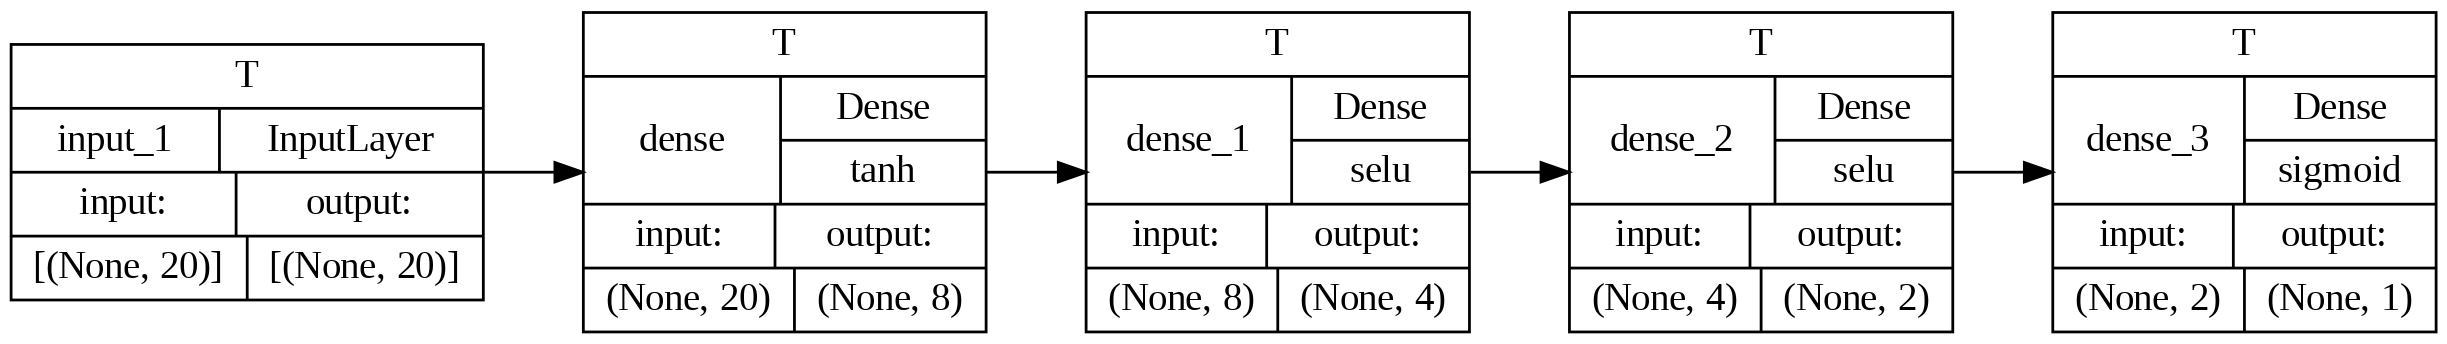

In [46]:
# 2.3 - Visualization of model_1_b 
plot_model(model_1_b, to_file='model_plot_1_b.png', show_shapes=True, rankdir='LR',#'LR':plot horizontally 
    show_layer_names=True, show_layer_activations = True, show_trainable=True, dpi = 200)

# 3. Multiclass Training Using MLPs for Intrusion Detection
The procedures of chapter 2 are repeated, adjusted for the multiclass configuration.

In [47]:
# 3.1 - Defining the model architectures

# Renaming the scaled data:
[X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m] = processed_data_m

# Number of units in the Input layer
input_shape = X_train_m.shape[1]

# Multiclass model: model_1_m - The "minimal" architecture
model_1_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# Multiclass model: model_2_m - An intermediate architecture
model_2_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# Multiclass model: model_3_m - An intermediate architecture
model_3_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# multiclass model: model_4_m - An intermediate architecture
model_4_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(16, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(16, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

# multiclass model: model_5_m - The "maximal" architecture
model_5_m = Sequential([
    Input(shape=(input_shape,)),
    Dense(32, activation='tanh', kernel_initializer=GlorotUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(32, activation='selu', kernel_initializer=HeUniform()),
    Dense(num_classes, activation='softmax', kernel_initializer=GlorotUniform())])

models_m = [model_1_m, model_2_m, model_3_m, model_4_m, model_5_m]
# Extract summary for models
_, _, _, _, _ = [model.summary() for model in models_m]
# Extract the number of parameters for each model
num_params_m  = [model.count_params() for model in models_m]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 16)                336       
                                                                 
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 dense_33 (Dense)            (None, 15)                255       
                                                                 
Total params: 863 (3.37 KB)
Trainable params: 863 (3.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                336       
                                                                 
 d

In [48]:
# 3.2 - Defining parameters for the Training Sessions under Multiclass configuration

# Define Early Stopping callback to monitor validation loss
early_stopping_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=8,                # Stop training after 10 epochs with no improvement
    verbose=1,                 # Provide verbose output when early stopping is triggered
    restore_best_weights=True) # Restore model weights with best validation loss

# Define ReduceLROnPlateau scheduler, LR:Learning Rate
reduce_lr_params = dict(
    monitor='val_accuracy',    # Monitor validation accuracy
    patience=4,                # Default value for patience is 10
    min_lr= 1e-07,             # min_lr: Minimum learning rate (deafault value=0.0001)
    verbose=0,                 # Providing verbose output when learning rate is reduced
    factor= 0.1)               # The default factor is 0.1, which reduces 
                               # the learning rate by 10% when triggered.
    
compilation_params_m = dict(
    optimizer='adam',          # Adam optimizer has default learning rate 1e-03
    loss='sparse_categorical_crossentropy',  # Sparse categoriical crossentropy 
                                             # corresponds to Multiclass Configuration 
    metrics=['accuracy'])      # montitor accuracy during training

In [49]:
# 3.2.1 - Training Session for `model_1_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_1_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_1_m = model_1_m.fit(**fitting_params_m)

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping


In [50]:
# 3.2.2 - Training Session for `model_2_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_2_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_2_m = model_2_m.fit(**fitting_params_m)

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


In [51]:
# 3.2.3 - Training Session for `model_3_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_3_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_3_m = model_3_m.fit(**fitting_params_m)

Restoring model weights from the end of the best epoch: 23.
Epoch 31: early stopping


In [52]:
# 3.2.4 - Training Session for `model_4_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_4_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_4_m = model_4_m.fit(**fitting_params_m)

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping


In [53]:
# 3.2.5 - Training Session for `model_5_m`

# Define Early Stopping callback to monitor validation loss in every training session
early_stopping = EarlyStopping(**early_stopping_params)

# Define ReduceLROnPlateau scheduler, LR:Learning Rate in every training session
reduce_lr = ReduceLROnPlateau(**reduce_lr_params)
    
# Compile the model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
model_5_m.compile(**compilation_params_m) 

# Parameters of the training session
fitting_params_m = dict(x=X_train_m, y=y_train_m, validation_data=(X_val_m, y_val_m),
    epochs=250, batch_size = 1024, callbacks=[early_stopping, reduce_lr], verbose=0)

# Train the model
history_5_m = model_5_m.fit(**fitting_params_m)

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping


In [60]:
# 3.3.1 - Standard Evaluation

def evaluate_m(model, X_test, y_test):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    recall    = recall_score(y_test, y_pred_labels, average='weighted', zero_division=1)
    f1        = f1_score(y_test, y_pred_labels, average='weighted', zero_division=1)

    # Print the evaluation metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Test Precision: {precision*100:.2f}%")
    print(f"Test Recall:    {recall*100:.2f}%")
    print(f"Test F1 Score:  {f1*100:.2f}%")
    print("")
    
    return test_loss, test_accuracy, precision, recall, f1
    
[loss_1_m, acc_1_m, prec_1_m, recall_1_m, f1_1_m] = evaluate_m(model_1_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_2_m, acc_2_m, prec_2_m, recall_2_m, f1_2_m] = evaluate_m(model_2_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_3_m, acc_3_m, prec_3_m, recall_3_m, f1_3_m] = evaluate_m(model_3_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_4_m, acc_4_m, prec_4_m, recall_4_m, f1_4_m] = evaluate_m(model_4_m,
                X_test=X_test_m, y_test=y_test_m)
[loss_5_m, acc_5_m, prec_5_m, recall_5_m, f1_5_m] = evaluate_m(model_5_m,
                X_test=X_test_m, y_test=y_test_m)

10462/10462 [==============================] - 10s 963us/step
Test Loss:      0.3023
Test Accuracy:  89.48%
Test Precision: 89.60%
Test Recall:    89.48%
Test F1 Score:  88.82%

10462/10462 [==============================] - 10s 991us/step
Test Loss:      0.3096
Test Accuracy:  89.08%
Test Precision: 88.26%
Test Recall:    89.08%
Test F1 Score:  87.83%

10462/10462 [==============================] - 10s 997us/step
Test Loss:      0.2829
Test Accuracy:  89.84%
Test Precision: 88.87%
Test Recall:    89.84%
Test F1 Score:  87.19%

10462/10462 [==============================] - 11s 1ms/step
Test Loss:      0.2574
Test Accuracy:  89.50%
Test Precision: 91.86%
Test Recall:    89.50%
Test F1 Score:  89.87%

10462/10462 [==============================] - 11s 1ms/step
Test Loss:      0.2155
Test Accuracy:  91.01%
Test Precision: 92.37%
Test Recall:    91.01%
Test F1 Score:  91.34%



In [61]:
# 3.3.2 - Advanced Evaluation

def far(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the False Positives of the Benign Class
    false_positives = total_benign_instances - conf_matrix[benign_index, benign_index]
    # Calculate FAR
    far = false_positives / total_benign_instances
    return far

def amr(conf_matrix, benign_index):
    # Calculate the total number of instances for the Benign Class
    total_benign_instances = np.sum(conf_matrix[benign_index,:])
    # Calculate the total number of instances for all classes
    total_instances = np.sum(conf_matrix)
    # Extract the total number of attack/malicious instances
    total_attack_instances = total_instances - total_benign_instances
    # Calculate the False Positives for the union of all attacks
    false_positives = np.sum(conf_matrix[benign_index + 1:, benign_index], axis=0)
    # Calculate AMR
    amr = false_positives / total_attack_instances
    return amr

def far_amr_m(model, X_test=X_test_m, y_test=y_test_m, plotting=True):
    """
    Advanced evaluation through False Alarm Ratio (FAR) & Attack Miss Ratio (AMR).
    """
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_labels)

    # Plotting parameter exists for debugging purposes
    if plotting:
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    far_m = far(conf_matrix=conf_matrix, benign_index=0)
    amr_m = amr(conf_matrix=conf_matrix, benign_index=0)
    return far_m, amr_m
    
far_1_m, amr_1_m = far_amr_m(model_1_m, plotting=False)
far_2_m, amr_2_m = far_amr_m(model_2_m, plotting=False)
far_3_m, amr_3_m = far_amr_m(model_3_m, plotting=False)
far_4_m, amr_4_m = far_amr_m(model_4_m, plotting=False)
far_5_m, amr_5_m = far_amr_m(model_5_m, plotting=False)

print("")
print(f"Model_1_m: (FAR, AMR) = ({far_1_m:.4f}, {amr_1_m:.4f})")
print(f"Model_2_m: (FAR, AMR) = ({far_2_m:.4f}, {amr_2_m:.4f})")
print(f"Model_3_m: (FAR, AMR) = ({far_3_m:.4f}, {amr_3_m:.4f})")
print(f"Model_4_m: (FAR, AMR) = ({far_4_m:.4f}, {amr_4_m:.4f})")
print(f"Model_5_m: (FAR, AMR) = ({far_5_m:.4f}, {amr_5_m:.4f})")

10462/10462 [==============================] - 11s 1ms/step

Model_1_m: (FAR, AMR) = (0.0464, 0.3597)
Model_2_m: (FAR, AMR) = (0.0439, 0.4372)
Model_3_m: (FAR, AMR) = (0.0186, 0.5017)
Model_4_m: (FAR, AMR) = (0.0805, 0.1460)
Model_5_m: (FAR, AMR) = (0.0642, 0.1490)


History for model_1_m



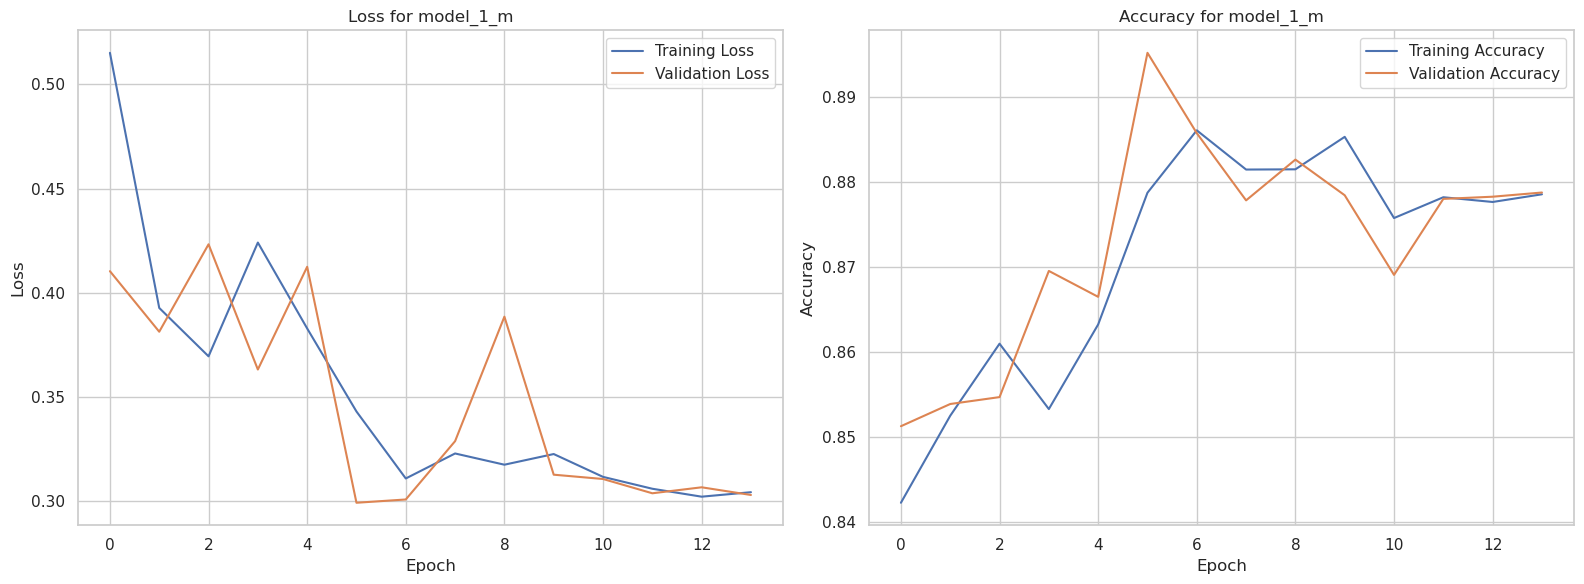


History for model_2_m



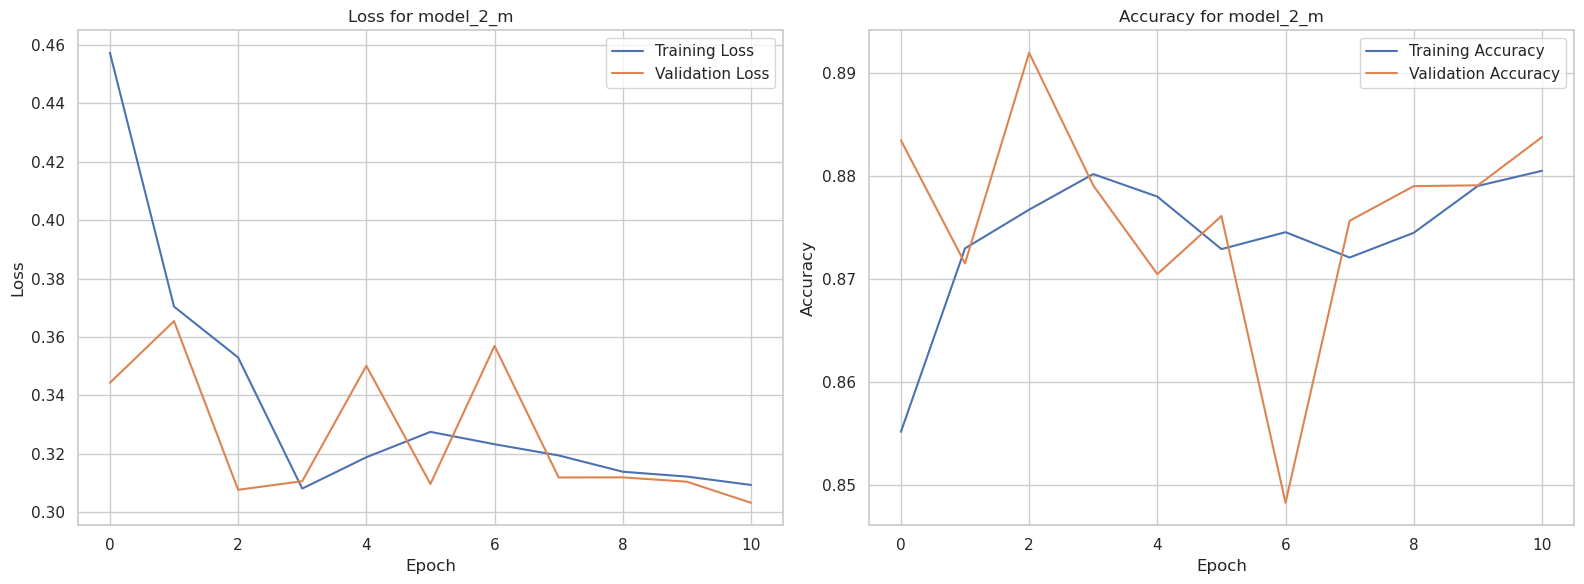


History for model_3_m



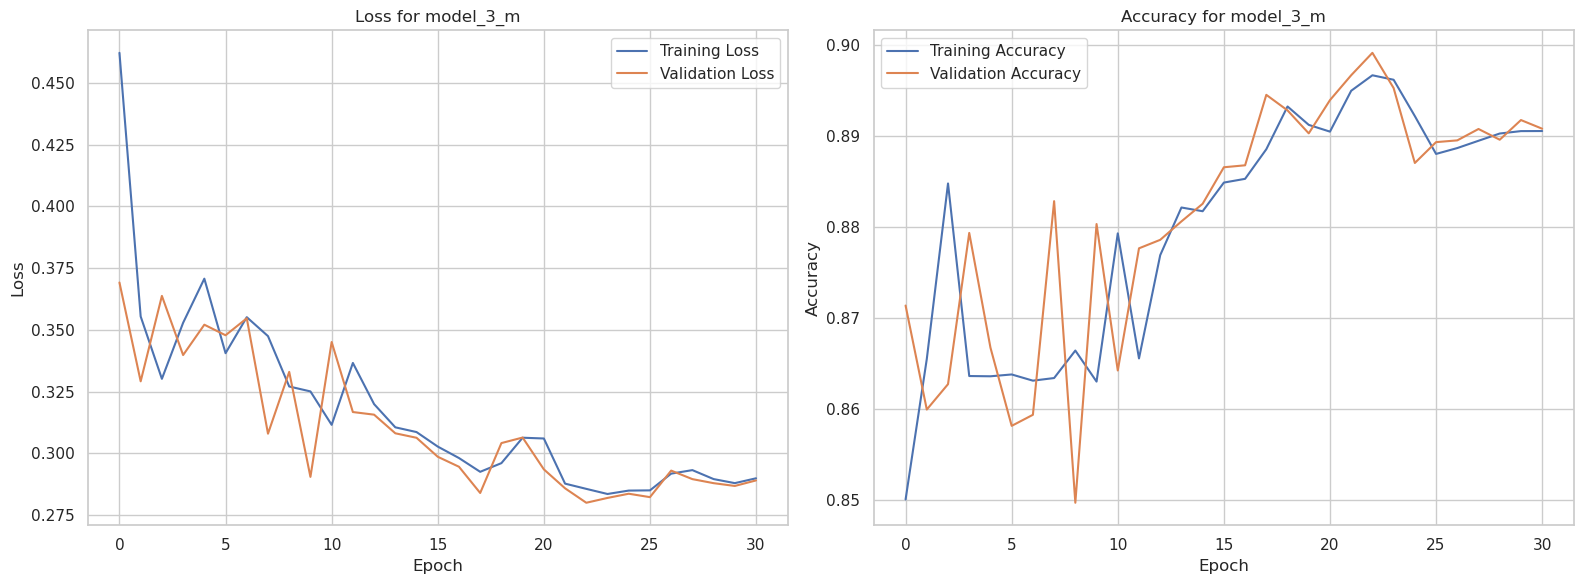


History for model_4_m



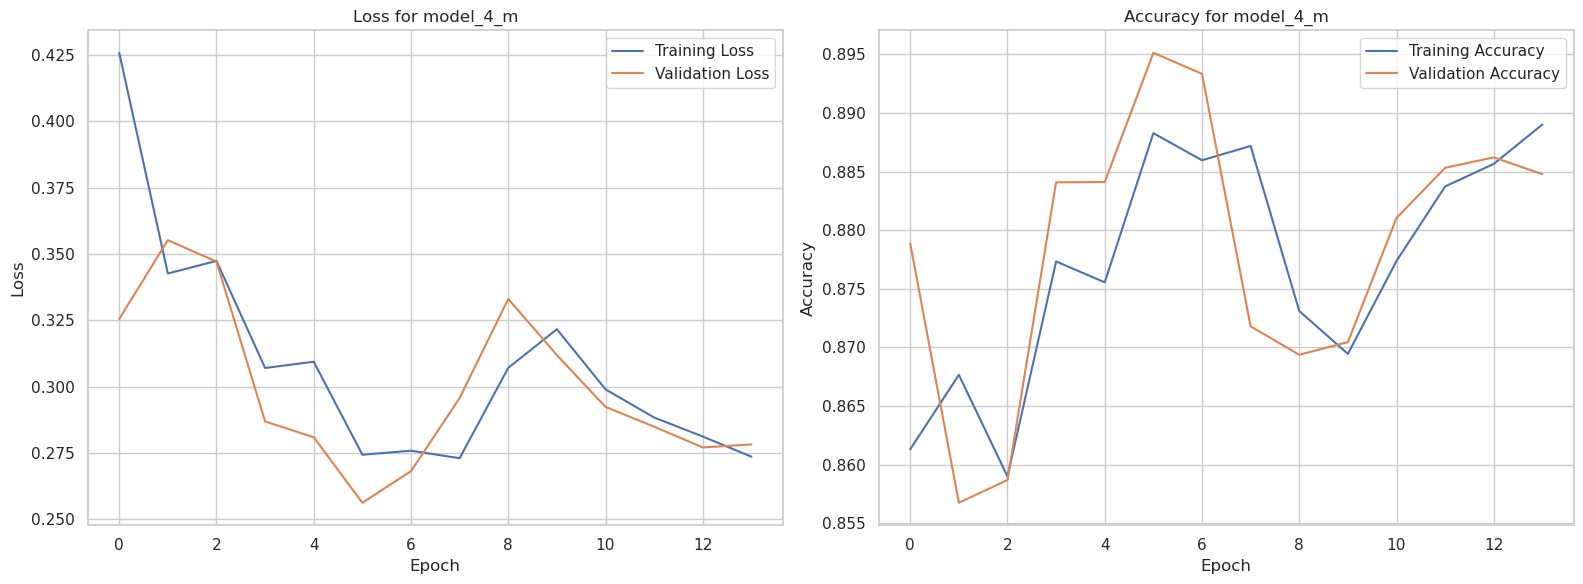


History for model_5_m



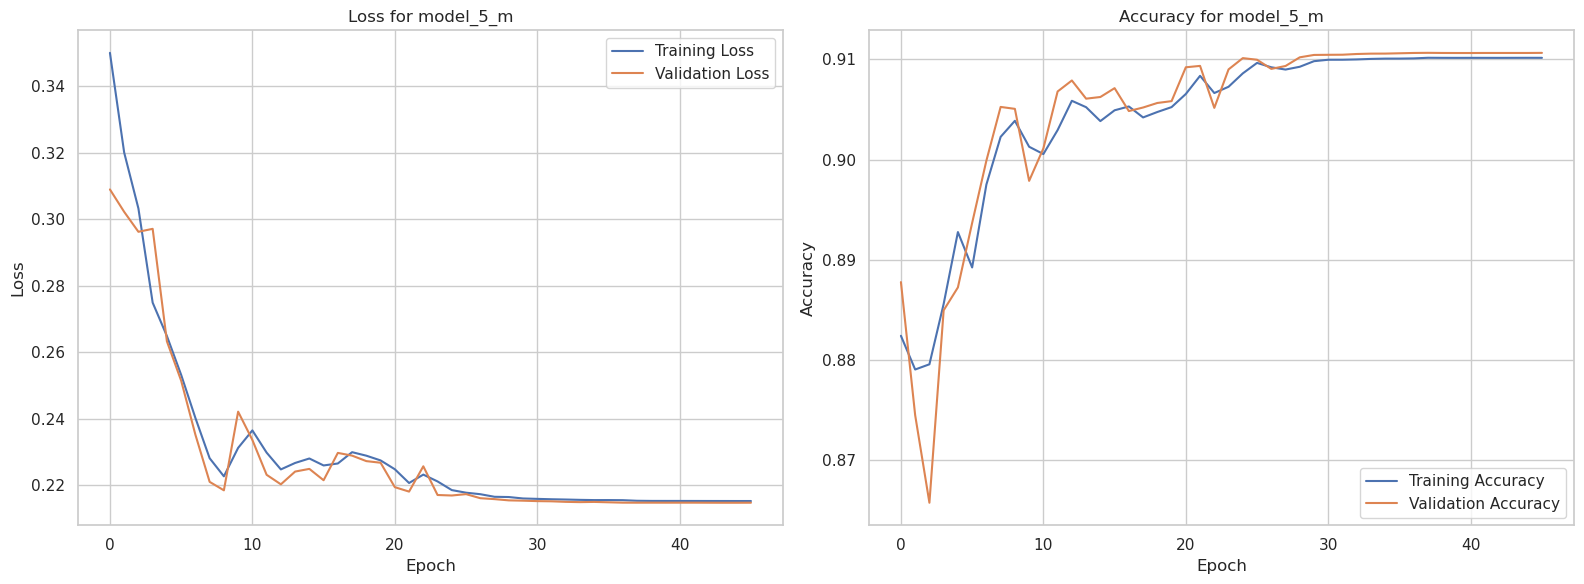

In [62]:
# 3.4.1 - Plotting history: train & validation loss and accuracy over epochs

print("History for model_1_m\n")
history_plot(history_1_m, "model_1_m")
print("")
print("History for model_2_m\n")
history_plot(history_2_m, "model_2_m")
print("")
print("History for model_3_m\n")
history_plot(history_3_m, "model_3_m")
print("")
print("History for model_4_m\n")
history_plot(history_4_m, "model_4_m")
print("")
print("History for model_5_m\n")
history_plot(history_5_m, "model_5_m")

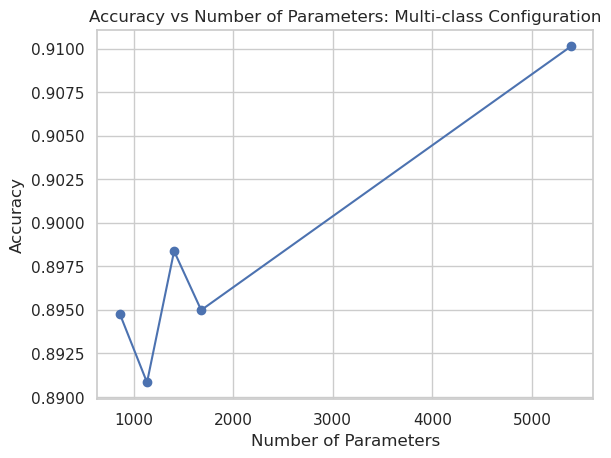

In [63]:
# 3.4.2 - Plotting accuracy vs. number of parameters trade-off

acc_m = [acc_1_m, acc_2_m, acc_3_m, acc_4_m, acc_5_m]

# Plot
plt.plot(num_params_m, acc_m, marker='o')
plt.title('Accuracy vs Number of Parameters: Multi-class Configuration')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [64]:
# 3.5 - Measure latency

# Measure & Print latency
print(f"Latency for model_1_m: {latency(model_1_m, X_test_m)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_2_m: {latency(model_2_m, X_test_m)*1000:.3f} ms") # Results: 0.052 m-seconds
print(f"Latency for model_3_m: {latency(model_3_m, X_test_m)*1000:.3f} ms") # Results: 0.053 m-seconds
print(f"Latency for model_4_m: {latency(model_4_m, X_test_m)*1000:.3f} ms") # Results: 0.051 m-seconds
print(f"Latency for model_5_m: {latency(model_5_m, X_test_m)*1000:.3f} ms") # Results: 0.049 m-seconds

10462/10462 [==============================] - 10s 952us/step
Latency for model_1_m: 0.038 ms
10462/10462 [==============================] - 10s 997us/step
Latency for model_2_m: 0.040 ms
10462/10462 [==============================] - 11s 1ms/step
Latency for model_3_m: 0.040 ms
10462/10462 [==============================] - 11s 1ms/step
Latency for model_4_m: 0.042 ms
10462/10462 [==============================] - 11s 1ms/step
Latency for model_5_m: 0.040 ms


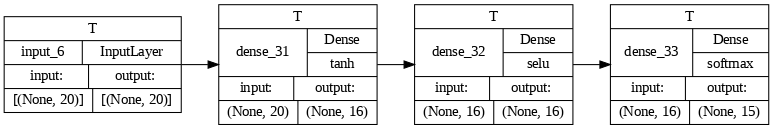

In [65]:
# 3.3 - Visualization of model_1_m 
plot_model(model_1_m, to_file='model_plot_1_m.png', show_shapes=True, rankdir='LR',#'LR':plot horizontally 
    show_layer_names=True, show_layer_activations = True, show_trainable=True, dpi = 75)